In [1]:
import torch
import torch.nn as nn
import pandas as pd
import spacy
from textblob import TextBlob
import nltk
import numpy as np
import nltk.data
from spacy.gold import biluo_tags_from_offsets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
train_df =  pd.read_csv(".\\data\\train.csv",header=None,names=["question","paragraph","answer_span","start","end"])
dev_df =  pd.read_csv(".\\data\\dev.csv",header=None,names=["question","paragraph","answer_span","start","end"])

In [4]:
train_df.head()

,question,paragraph,answer_span,start,end
0,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269,286
1,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207,226
2,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526,530
3,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166,180
4,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276,286


In [5]:
dev_df.head()

,question,paragraph,answer_span,start,end
0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,France,159,165
1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,10th and 11th centuries,94,117
2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,"Denmark, Iceland and Norway",256,283
3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,Rollo,308,313
4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,10th century,671,683


In [6]:
train_df["q_len"]=train_df["question"].map(lambda question: len(question.split()))
train_df["p_len"]=train_df["paragraph"].map(lambda paragraph: len(paragraph.split()))
train_df["answer_span_len"]=train_df["answer_span"].map(lambda answer_span: len(str(answer_span).split()))
train_df.head()

,question,paragraph,answer_span,start,end,q_len,p_len,answer_span_len
0,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269,286,6,109,4
1,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207,226,11,109,3
2,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526,530,11,109,1
3,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166,180,9,109,2
4,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276,286,7,109,2


In [7]:
dev_df["q_len"]=dev_df["question"].map(lambda question: len(question.split()))
dev_df["p_len"]=dev_df["paragraph"].map(lambda paragraph: len(paragraph.split()))
dev_df["answer_span_len"]=train_df["answer_span"].map(lambda answer_span: len(str(answer_span).split()))
dev_df.head()

,question,paragraph,answer_span,start,end,q_len,p_len,answer_span_len
0,In what country is Normandy located?,The Normans (Norman: Nourmands; French: Norman...,France,159,165,6,113,4
1,When were the Normans in Normandy?,The Normans (Norman: Nourmands; French: Norman...,10th and 11th centuries,94,117,6,113,3
2,From which countries did the Norse originate?,The Normans (Norman: Nourmands; French: Norman...,"Denmark, Iceland and Norway",256,283,7,113,1
3,Who was the Norse leader?,The Normans (Norman: Nourmands; French: Norman...,Rollo,308,313,5,113,2
4,What century did the Normans first gain their ...,The Normans (Norman: Nourmands; French: Norman...,10th century,671,683,10,113,2


In [8]:
def sentence_tokenizer(paragraph,tokenizer="textblob"):
    if tokenizer=="spacy":
        doc = nlp(paragraph)
        sentences = [sent.text for sent in doc.sents]
        return sentences,len(sentences)
    elif tokenizer=="nltk":    
        sentences = TextBlob(paragraph)
        return sentences,len(sentences)
    else:
        sentences = nltk.tokenize.sent_tokenize(paragraph)
        return sentences,len(sentences)


In [9]:
train_df["sentences"]=train_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph)[0])   
train_df["sentences_len"]=train_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph)[1]) #waste cpu 

In [10]:
dev_df["sentences"]=dev_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph)[0])   
dev_df["sentences_len"]=dev_df["paragraph"].map(lambda paragraph: sentence_tokenizer(paragraph)[1]) #waste cpu 

In [11]:
def generate_target(sentences,start_char_idx):
    target = 1
    tar = 0 
    for i in sentences:
        tar = tar + len(i)
        if(tar<start_char_idx):
          target +=1
    return target

In [12]:
train_df["target"]=train_df.apply(lambda row: generate_target(row[8],row[3]),axis=1)
dev_df["target"]=dev_df.apply(lambda row: generate_target(row[8],row[3]),axis=1)

In [13]:
train_df.describe()

,start,end,q_len,p_len,answer_span_len,sentences_len,target
count,86821.000000,86821.000000,86821.000000,86821.000000,86821.000000,86821.000000,86821.000000
mean,319.806475,339.955644,10.066378,119.794347,3.162772,5.105435,2.715864
std,266.390192,267.705780,3.555650,49.409714,3.390947,2.333043,1.837105
min,0.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000
25%,111.000000,131.000000,8.000000,89.000000,1.000000,4.000000,1.000000
50%,262.000000,282.000000,10.000000,110.000000,2.000000,5.000000,2.000000
75%,468.000000,491.000000,12.000000,142.000000,4.000000,6.000000,4.000000
max,3126.000000,3136.000000,40.000000,653.000000,43.000000,27.000000,22.000000


In [14]:
dev_df.describe()

,start,end,q_len,p_len,answer_span_len,sentences_len,target
count,5928.000000,5928.000000,5928.000000,5928.000000,5928.000000,5928.000000,5928.000000
mean,343.593455,364.509615,10.363360,128.505735,2.410762,5.383266,2.817814
std,295.443209,297.898886,3.682464,57.430026,2.157881,2.514383,1.984045
min,0.000000,3.000000,3.000000,25.000000,1.000000,1.000000,1.000000
25%,120.000000,141.000000,8.000000,93.000000,1.000000,4.000000,1.000000
50%,285.500000,305.000000,10.000000,114.000000,2.000000,5.000000,2.000000
75%,489.250000,513.000000,12.000000,149.000000,3.000000,6.000000,4.000000
max,2922.000000,2951.000000,31.000000,629.000000,43.000000,29.000000,28.000000


In [15]:
train_df["p_len"].quantile([.8,0.9])

0.8    152.0
0.9    183.0
Name: p_len, dtype: float64

In [16]:
dev_df["p_len"].quantile([.8,0.9])

0.8    156.0
0.9    191.0
Name: p_len, dtype: float64

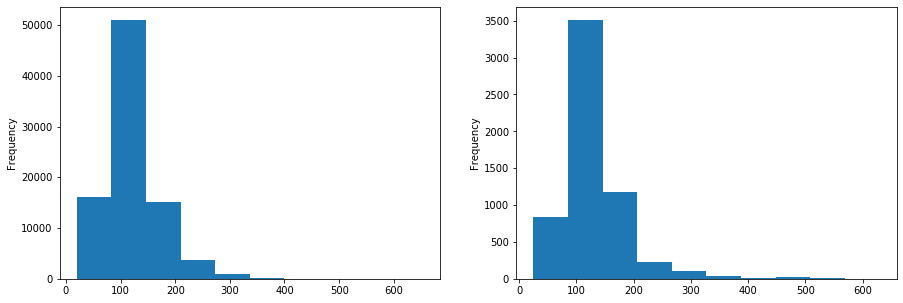

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df['p_len'].plot.hist(ax=axes[0])
dev_df['p_len'].plot.hist(ax=axes[1])
plt.show()

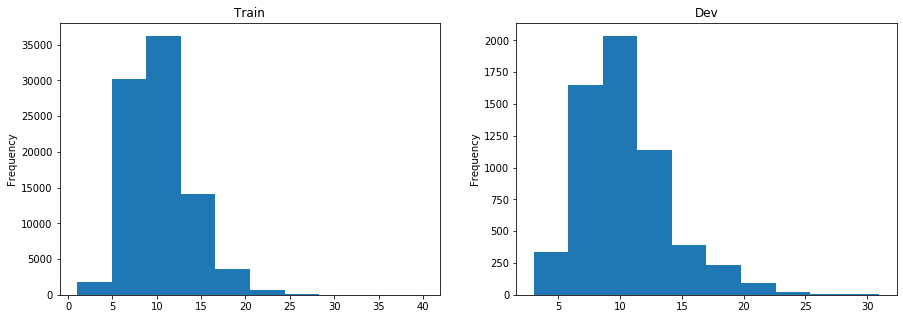

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df['q_len'].plot.hist(ax=axes[0],title="Train")
dev_df['q_len'].plot.hist(ax=axes[1],title="Dev")
plt.show()

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df['answer_span_len'].plot.pie(ax=axes[0],title="Train",legend=True, autopct='%1.1f%%',labels=None)
dev_df['answer_span_len'].plot.pie(ax=axes[1],title="Dev",legend=True, autopct='%1.1f%%',labels=None)
plt.show()

ValueError: Image size of 757x1302353 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x360 with 2 Axes>

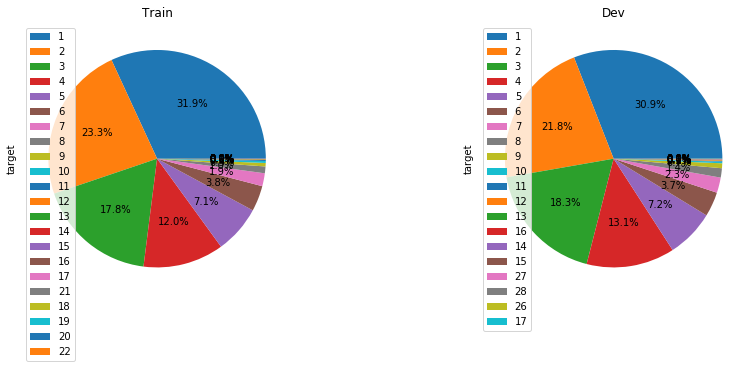

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df['target'].value_counts().plot.pie(ax=axes[0],title="Train",legend=True, autopct='%1.1f%%',labels=None)
dev_df['target'].value_counts().plot.pie(ax=axes[1],title="Dev",legend=True, autopct='%1.1f%%',labels=None)
plt.show()

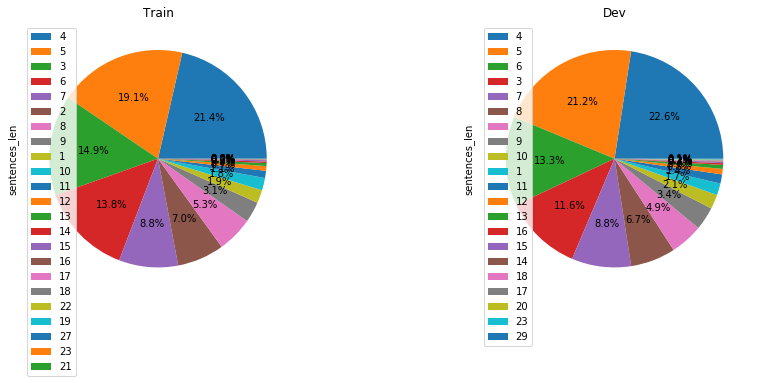

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df['sentences_len'].value_counts().plot.pie(ax=axes[0],title="Train",legend=True, autopct='%1.1f%%',labels=None)
dev_df['sentences_len'].value_counts().plot.pie(ax=axes[1],title="Dev",legend=True, autopct='%1.1f%%',labels=None)
plt.show()

In [22]:
min_sent= 3
max_sent = 10
train_df = train_df[(train_df["sentences_len"] >= min_sent) & (train_df["sentences_len"] <= max_sent)]
dev_df = dev_df[(dev_df["sentences_len"] >= min_sent) & (dev_df["sentences_len"] <= max_sent)]

In [23]:
print("Training Shape",train_df.shape,"validation shape",dev_df.shape)

Training Shape (76596, 11) validation shape (5319, 11)


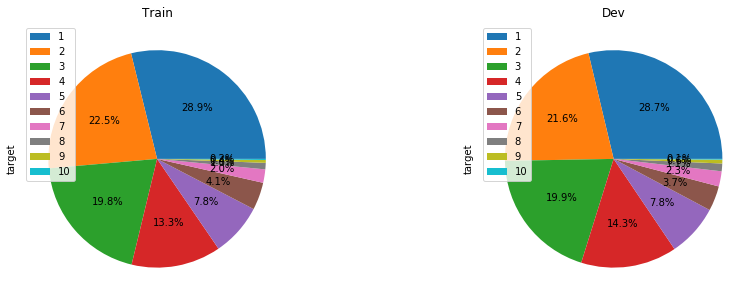

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df['target'].value_counts().plot.pie(ax=axes[0],title="Train",legend=True, autopct='%1.1f%%',labels=None)
dev_df['target'].value_counts().plot.pie(ax=axes[1],title="Dev",legend=True, autopct='%1.1f%%',labels=None)
plt.show()

In [25]:
train_df.head()

,question,paragraph,answer_span,start,end,q_len,p_len,answer_span_len,sentences,sentences_len,target
0,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269,286,6,109,4,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2
1,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207,226,11,109,3,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2
2,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526,530,11,109,1,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,4
3,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166,180,9,109,2,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2
4,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276,286,7,109,2,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2


In [26]:
wh_words = ["what","who","when","which","how","where","why","whose","whom"]
def get_wh_word(question):
    temp = "others"
    for i in wh_words:
        if i in question.lower().split():
            temp = i
    return temp

In [27]:
train_df["wh_word"] = train_df["question"].apply(lambda row: get_wh_word(row))
dev_df["wh_word"] = dev_df["question"].apply(lambda row: get_wh_word(row))

In [28]:
train_df.head()

,question,paragraph,answer_span,start,end,q_len,p_len,answer_span_len,sentences,sentences_len,target,wh_word
0,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,in the late 1990s,269,286,6,109,4,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2,when
1,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,singing and dancing,207,226,11,109,3,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2,when
2,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,2003,526,530,11,109,1,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,4,when
3,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"Houston, Texas",166,180,9,109,2,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2,what
4,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,late 1990s,276,286,7,109,2,[Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ ...,4,2,which


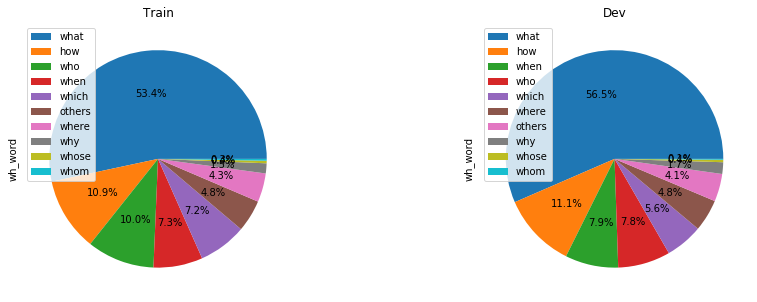

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
train_df["wh_word"].value_counts().plot.pie(ax=axes[0],title="Train",legend=True, autopct='%1.1f%%',labels=None)
dev_df["wh_word"].value_counts().plot.pie(ax=axes[1],title="Dev", legend=True, autopct='%1.1f%%',labels=None)
plt.show()